## Import Required Libraries and Initialize Constants

In [1]:
import os
import re
import random
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from email import policy
from email.parser import BytesParser
from sklearn.metrics import confusion_matrix, classification_report
from pyvis.network import Network
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Replace with your real IPinfo token (or set to None to skip IPinfo lookups)
IPINFO_TOKEN = "7c7088cbc3a2d1"
DATA_FOLDER  = "data/test"


## Define Helper Functions

In [2]:
def parse_email_headers(path):
    """
    Unified header extractor: works on real .eml (MIME) or plain-text dumps.
    Returns a dict with:
      - file_name
      - return_path
      - message_id
      - received  (list of Received: lines)
      - ips       (unique list of IPv4s seen in Received hops)
    """
    raw = open(path, "rb").read()

    # Attempt full .eml parsing first
    try:
        msg = BytesParser(policy=policy.default).parsebytes(raw)
        return_path  = msg.get("Return-Path", "")
        message_id   = msg.get("Message-ID", "")
        received_hdr = msg.get_all("Received", []) or []
    except Exception:
        # Fallback: manual plain-text parse
        text = None
        try:
            text = raw.decode("utf-8")
        except UnicodeDecodeError:
            text = raw.decode("latin1", errors="ignore")

        # Split off headers (up to first blank line)
        parts = re.split(r"\r?\n\r?\n", text, maxsplit=1)
        header_block = parts[0].splitlines()

        return_path = ""
        message_id  = ""
        received_hdr = []

        current_hdr = None
        for line in header_block:
            # Continuation line?
            if line.startswith((" ", "\t")) and current_hdr == "Received":
                # fold into the last Received entry
                received_hdr[-1] += " " + line.strip()
                continue

            # New header line?
            m = re.match(r"^(Return-Path|Message-ID|Received):\s*(.*)$", line)
            if m:
                hdr_name, hdr_val = m.group(1), m.group(2).strip()
                current_hdr = hdr_name
                if hdr_name == "Return-Path":
                    return_path = hdr_val
                elif hdr_name == "Message-ID":
                    message_id = hdr_val
                elif hdr_name == "Received":
                    received_hdr.append(hdr_val)
            else:
                current_hdr = None

    # Pull IPv4s out of each Received line
    ips = []
    for line in received_hdr:
        ips += re.findall(r"\[?(\d{1,3}(?:\.\d{1,3}){3})\]?", line)
    ips = list(dict.fromkeys(ips))  # dedupe, preserve order

    return {
        "file_name":   os.path.basename(path),
        "return_path": return_path,
        "message_id":  message_id,
        "received":    received_hdr,
        "ips":         ips
    }

def lookup_ipinfo(ip):
    """Call ipinfo.io to get org/country/loc for an IP."""
    if not IPINFO_TOKEN:
        return {"ip": ip}
    url  = f"https://ipinfo.io/{ip}/json?token={IPINFO_TOKEN}"
    data = requests.get(url).json()
    return {
        "ip":      ip,
        "org":     data.get("org", ""),
        "country": data.get("country", ""),
        "loc":     data.get("loc", "")
    }

def build_attack_graph(headers):
    """Build directed graph edges from each hop to the next."""
    G = nx.DiGraph()
    for h in headers:
        for a, b in zip(h["ips"], h["ips"][1:]):
            G.add_edge(a, b)
    return G

# Fix seed for consistent results
DetectorFactory.seed = 0

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except LangDetectException:
        return "unknown"

# Replace URLs and bare domains with <URL>
def replace_links(text):
    """Substitute all URLs and bare-domain patterns with the placeholder '<URL>'."""
    text = re.sub(r'https?://\S+|www\.\S+', '<URL>', text)
    text = re.sub(
        r'\b[\w\.-]+\.(com|org|net|edu|gov|io|co)(/[^\s]*)?\b',
        '<URL>',
        text
    )
    return text

def extract_email_body(path):
    with open(path, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)

    # Walk through the email parts to find the plain text
    for part in msg.walk():
        content_type = part.get_content_type()
        content_disposition = str(part.get_content_disposition())

        # Skip attachments
        if content_disposition == 'attachment':
            continue

        if content_type == 'text/plain':
            return part.get_content()

    # Fallback if no text/plain found, try to get payload raw
    return msg.get_payload(decode=True).decode(errors='ignore')

def categorize_email(path):
    """
    Read a plain-text email dump from `path`, then:
      - scan for URLs
      - score keyword hits across categories
      - apply priority overrides (malware > phishing > scam)
      - assign category if score >= min_hits, else 'mixed'
    """
    # Load the whole file as text
    try:
        body = extract_email_body(path)
        body = replace_links(body)
    except Exception:
        # Fallback: read and decode raw
        raw = open(path, 'rb').read()
        try:
            body = raw.decode('utf-8')
            body = replace_links(body)
        except UnicodeDecodeError:
            body = raw.decode('latin1', errors='ignore')
            body = replace_links(body)

    lower = body.lower()

    # Define categories & keywords
    categories = {
        "phishing":  [
            "account", "verify", "password", "urgent", "login", "click",
            "bank", "secure", "alert", "suspend", "transaction", "confirm", "credentials"
        ],
        "promotion": [
            "sale", "discount", "offer", "free", "deal", "subscribe",
            "limited time", "clearance", "coupon", "bargain", "promo", "save", "special"
        ],
        "news":      [
            "update", "today", "news", "breaking", "report", "newsletter",
            "headline", "alert", "bulletin", "press release", "coverage", "journal"
        ],
        "malware":   [
            "attachment", ".exe", ".zip", "download", "run",
            "virus", "trojan", "payload", "malicious", "infected", ".scr", ".bat"
        ],
        "scam":      [
            "lottery", "winner", "prize", "inheritance", "funds", "urgent payment",
            "confidential", "wire transfer", "claim now"
        ],
        "notification": [
            "reminder", "notification", "alert", "system", "service", "maintenance",
            "outage", "downtime", "scheduled"
        ]
    }

    # Score each category
    scores = {cat: sum(lower.count(kw) for kw in kws)
              for cat, kws in categories.items()}
    
    # Detect language
    try:
        language = detect_language(body)
    except LangDetectException:
        language = "unknown"

    print(path)
    print(f"Detected language: {language}")

    # Pick the top-scoring category if it meets min_hits
    best_cat, best_count = max(scores.items(), key=lambda x: x[1])
    chosen = best_cat

    return {
        "file_name": os.path.basename(path),
        "category":  chosen,
        "language":  language,
    }


## Parse All Headers and Do IP Lookups

In [3]:
# Read the test‐set ground truth
gt = pd.read_csv(os.path.join(DATA_FOLDER, 'ground_truth.csv'), dtype=str)

# Build a set of the Spam basenames
spam_basenames = set(
    gt.loc[gt['true_label']=='Spam', 'file_name']
)

# Loop only over those files
headers_list = []
ipinfo_list  = []

for fn in sorted(os.listdir(DATA_FOLDER)):
    base, ext = os.path.splitext(fn)
    if base not in spam_basenames:
        continue

    path = os.path.join(DATA_FOLDER, fn)
    h    = parse_email_headers(path)
    headers_list.append(h)
    for ip in h["ips"]:
        ipinfo_list.append(lookup_ipinfo(ip))

df_headers = pd.DataFrame(headers_list)
df_ipinfo = pd.DataFrame(ipinfo_list).drop_duplicates("ip")


## Categorize Email

data/test\Spam1.91269fd2b14a1fa0f183ca60953b99af
Detected language: en
data/test\Spam10.39e7167813c411d9163ceedcba3b3702
Detected language: en
data/test\Spam100.b444b69845db2fa0a4693ca04e6ac5c5
Detected language: en
data/test\Spam101.eml
Detected language: ja
data/test\Spam102.eml
Detected language: ja
data/test\Spam103.eml
Detected language: en
data/test\Spam104.eml
Detected language: ja
data/test\Spam105.eml
Detected language: en
data/test\Spam106.eml
Detected language: ja
data/test\Spam107.eml
Detected language: ja
data/test\Spam108.eml
Detected language: ja
data/test\Spam109.eml
Detected language: ja
data/test\Spam11.43bfe86df65d53c5f7ca2365dc12582b
Detected language: en
data/test\Spam110.eml
Detected language: ja
data/test\Spam111.eml
Detected language: en
data/test\Spam112.eml
Detected language: ko
data/test\Spam113.eml
Detected language: ko
data/test\Spam114.eml
Detected language: en
data/test\Spam115.eml
Detected language: en
data/test\Spam116.eml
Detected language: en
data/tes

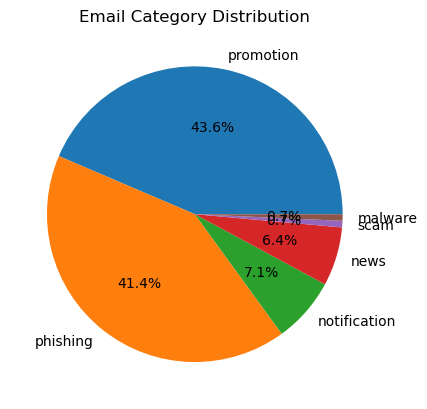

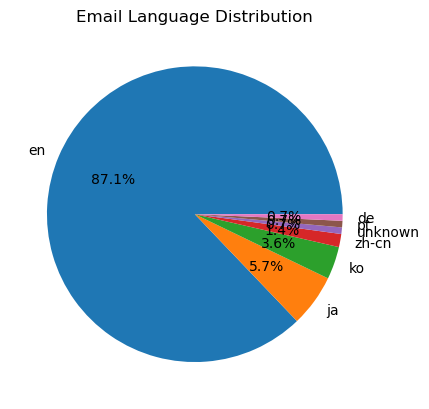

In [4]:
category_records = []
for h in headers_list:
    path = os.path.join(DATA_FOLDER, h["file_name"])
    category_records.append(categorize_email(path))

df_category = pd.DataFrame(category_records)
df_category[["file_name","category"]]

# Count the categories
cat_counts = df_category['category'].value_counts()

# Pie chart for Email Purpose (Category)
plt.figure()
plt.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%')
plt.title('Email Category Distribution')

# Language distribution
lang_counts = df_category['language'].value_counts()
plt.figure()
plt.pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%')
plt.title('Email Language Distribution')

plt.show()

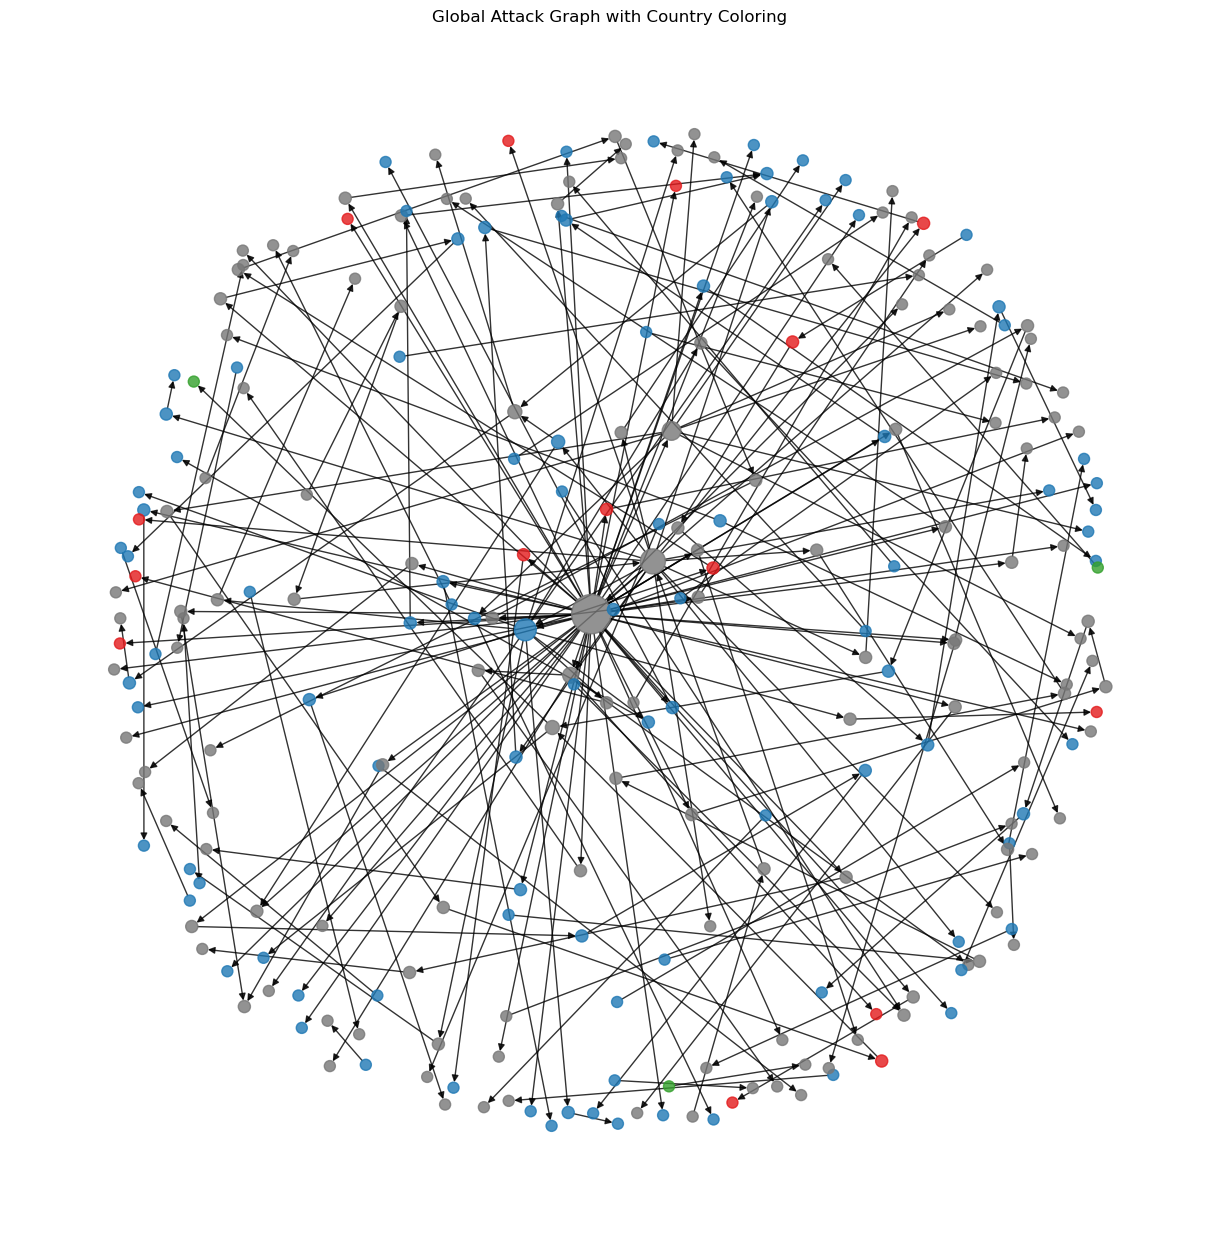

Wrote interactive filtered graph to trace_graph.html


In [5]:
# Build the attack graph
G = build_attack_graph(headers_list)

# Compute node‐size by degree (must come before any draw call)
deg = dict(G.degree())
min_size, max_size = 50, 800
sizes = [
    min_size + (deg[n] / max(deg.values())) * (max_size - min_size)
    for n in G.nodes()
]

# Shared layout for static plots
pos = nx.spring_layout(G, k=0.5, seed=42)

# Enrich IP info
all_ips = {ip for hdr in headers_list for ip in hdr['ips']}
ipinfo_list = [lookup_ipinfo(ip) for ip in all_ips]
df_ipinfo = pd.DataFrame(ipinfo_list).drop_duplicates(subset=['ip'])

# Geo‐ or frequency‐based coloring
geo_field = next((c for c in ('country_name','country','region','org')
                  if c in df_ipinfo.columns), None)

if geo_field:
    cmap = {'US':'#1f78b4','CN':'#e31a1c','DE':'#33a02c'}
    country_map = df_ipinfo.set_index('ip')[geo_field].to_dict()
    colors = [cmap.get(country_map.get(n,'Unknown'),'#777777') for n in G.nodes()]
    title = f"Global Attack Graph with Country Coloring"
else:
    country_map = { ip: 'Unknown' for ip in all_ips }
    freq = {}
    for hdr in headers_list:
        for ip in hdr['ips']:
            freq[ip] = freq.get(ip, 0) + 1
    maxf = max(freq.values())
    norm = {ip: freq[ip]/maxf for ip in freq}
    colors = [plt.cm.Blues(norm.get(n,0.0)) for n in G.nodes()]
    title = "Colored by hop-frequency"

# Static plot: geo/frequency coloring with correct sizes
plt.figure(figsize=(12,12))
nx.draw(G,
        pos=pos,
        node_color=colors,
        node_size=sizes,       # now defined above
        with_labels=False,
        alpha=0.8)
plt.title(title)
plt.show()

# Build IP→categories mapping
ip_categories = {}
for hdr in headers_list:
    cat = df_category.loc[
        df_category['file_name'] == hdr['file_name'],
        'category'
    ].iloc[0]
    for ip in hdr['ips']:
        ip_categories.setdefault(ip, set()).add(cat)

# Prepare country colors for PyVis
country_colors = {
    country: "#{:06x}".format(random.randint(0, 0xFFFFFF))
    for country in set(country_map.values())
}
fallback_color = '#777777'

# Build interactive PyVis network
net = Network(height='800px', width='100%', directed=True)
net.set_options("""
{
  "groups": {
    "phishing": { "shape": "dot", "size": 16 },
    "promotion": { "shape": "triangle", "size": 16 },
    "news": { "shape": "triangle", "size": 16 },
    "malware": { "shape": "triangle", "size": 16 },
    "scam": { "shape": "triangle", "size": 16 },
    "notification": { "shape": "square", "size": 16 },
    "other": { "shape": "square", "size": 16 }
  }
}
""")

for n in G.nodes():
    country    = country_map.get(n, 'Unknown')
    categories = ','.join(sorted(ip_categories.get(n, {'other'})))
    organization = df_ipinfo.loc[df_ipinfo['ip'] == n, 'org'].values[0] if n in df_ipinfo['ip'].values else 'Unknown'
    net.add_node(
        n,
        title=f"{n}\nCountry: {country}\nCategory: {categories}\nOrganization: {organization}",
        group=categories,
        value=deg[n],
        color=country_colors.get(country, fallback_color)
    )

for u, v in G.edges():
    net.add_edge(u, v)

# Write and post‐process HTML
html_path = 'trace_graph.html'
net.write_html(html_path, notebook=False)

filter_panel = """
<div id="filter-panel" style="position:absolute;top:10px;left:10px;
     background:white;padding:8px;border:1px solid #ccc;z-index:999;">
  <label><input type="checkbox" checked onclick="toggleGroup('phishing')"> Phishing</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('promotion')"> Promotion</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('news')"> News</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('malware')"> Malware</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('scam')"> Scam</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('notification')"> Notification</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('other')"> Other</label><br>
</div>
<script type="text/javascript">
  function toggleGroup(groupName) {
    const nodes = network.body.data.nodes.get({
      filter: node => node.group === groupName
    });
    const visible = document.querySelector(
      "input[onclick=\\"toggleGroup('" + groupName + "')\\"]"
    ).checked;
    nodes.forEach(n => {
      network.body.data.nodes.update({ id: n.id, hidden: !visible });
    });
  }
</script>
</body>
"""

with open(html_path, 'r', encoding='utf-8') as f:
    content = f.read()
content = content.replace('</body>', filter_panel)
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(content)

print(f"Wrote interactive filtered graph to {html_path}")


In [6]:
# Cell 6: Save CSV outputs (optional)

df_headers.to_csv("email_headers.csv", index=False)
df_ipinfo.to_csv("ipinfo_data.csv", index=False)
df_category.to_csv("email_category.csv", index=False)


## False Negative Tracing

data/test\Spam102.eml
Detected language: ja
data/test\Spam105.eml
Detected language: en
data/test\Spam107.eml
Detected language: ja
data/test\Spam108.eml
Detected language: ja
data/test\Spam109.eml
Detected language: ja
data/test\Spam110.eml
Detected language: ja
data/test\Spam111.eml
Detected language: en
data/test\Spam112.eml
Detected language: ko
data/test\Spam114.eml
Detected language: en
data/test\Spam115.eml
Detected language: en
data/test\Spam116.eml
Detected language: en
data/test\Spam119.eml
Detected language: en
data/test\Spam123.eml
Detected language: en
data/test\Spam124.eml
Detected language: en
data/test\Spam125.eml
Detected language: en
data/test\Spam126.eml
Detected language: en
data/test\Spam127.eml
Detected language: en
data/test\Spam128.eml
Detected language: en
data/test\Spam134.eml
Detected language: en
data/test\Spam21.f32dcf9a564da7e27f9fcad664cb0fe1
Detected language: en
data/test\Spam56.8d996c0bc08a47a90611de2e8a829048
Detected language: en
data/test\Spam62.794

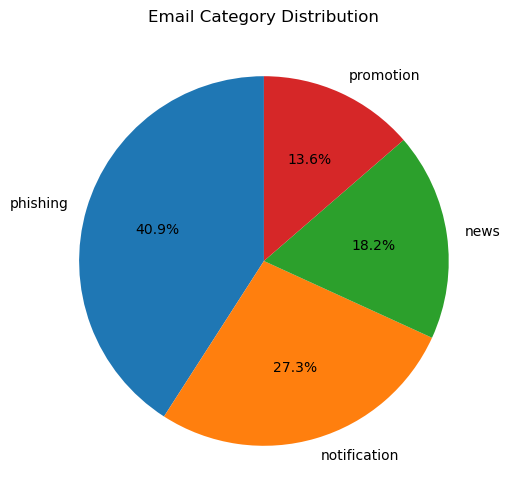

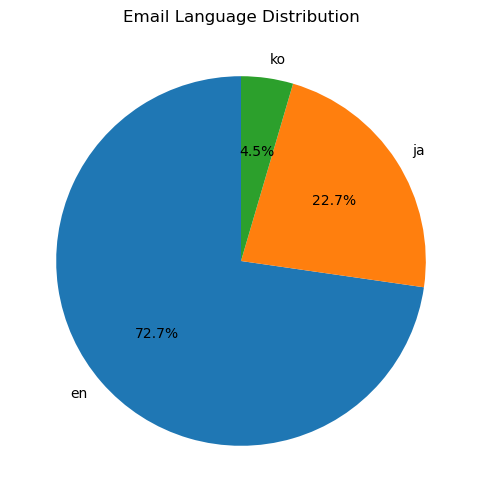

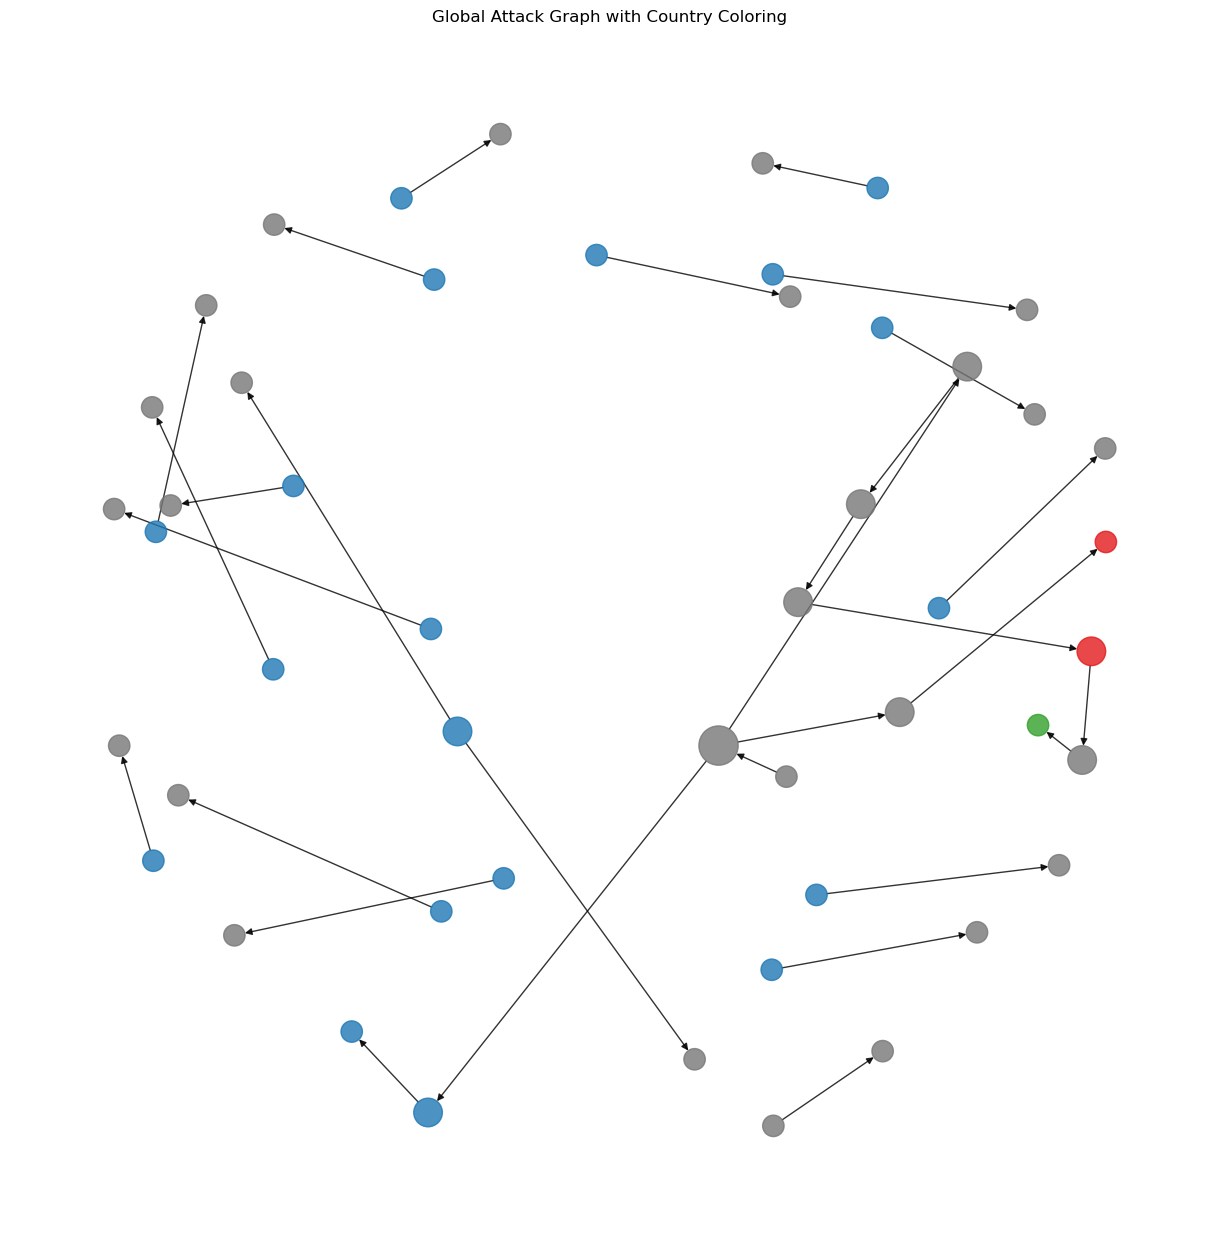

Wrote interactive filtered graph to false_negative_graph.html


In [7]:
# Spam list (basenames only)
my_spam_list = [
    "Spam21.f32dcf9a564da7e27f9fcad664cb0fe1",
    "Spam56.8d996c0bc08a47a90611de2e8a829048",
    "Spam62.794d3043053407d8e0c075a9a71902bd",
    "Spam102.eml",
    "Spam105.eml",
    "Spam107.eml",
    "Spam108.eml",
    "Spam109.eml",
    "Spam110.eml",
    "Spam111.eml",
    "Spam112.eml",
    "Spam114.eml",
    "Spam115.eml",
    "Spam116.eml",
    "Spam119.eml",
    "Spam123.eml",
    "Spam124.eml",
    "Spam125.eml",
    "Spam126.eml",
    "Spam127.eml",
    "Spam128.eml",
    "Spam134.eml",
]

# Normalize my_spam_list: remove extensions if needed for matching
my_spam_basenames = set(os.path.splitext(f)[0] for f in my_spam_list)

# Parse headers and collect IP info only for files in my_spam_list
headers_list = []
ipinfo_list = []

for fn in sorted(os.listdir(DATA_FOLDER)):
    base, ext = os.path.splitext(fn)
    if base not in my_spam_basenames:
        continue  # skip files not in your list

    path = os.path.join(DATA_FOLDER, fn)
    h = parse_email_headers(path)
    headers_list.append(h)
    for ip in h["ips"]:
        ipinfo_list.append(lookup_ipinfo(ip))

df_headers = pd.DataFrame(headers_list)
df_ipinfo = pd.DataFrame(ipinfo_list).drop_duplicates("ip")

# Step Categorize emails only for those in headers_list
category_records = []
for h in headers_list:
    path = os.path.join(DATA_FOLDER, h["file_name"])
    category_records.append(categorize_email(path))

df_category = pd.DataFrame(category_records)

# Step 3: Plot pie charts for category and language
cat_counts = df_category['category'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Email Category Distribution')
plt.show()

lang_counts = df_category['language'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Email Language Distribution')
plt.show()

# Build and plot the attack graph
G = build_attack_graph(headers_list)

deg = dict(G.degree())
min_size, max_size = 50, 800
sizes = [
    min_size + (deg[n] / max(deg.values())) * (max_size - min_size)
    for n in G.nodes()
]

pos = nx.spring_layout(G, k=0.5, seed=42)

# Enrich IP info again (optional if you want fresh df_ipinfo)
all_ips = {ip for hdr in headers_list for ip in hdr['ips']}
ipinfo_list = [lookup_ipinfo(ip) for ip in all_ips]
df_ipinfo = pd.DataFrame(ipinfo_list).drop_duplicates(subset=['ip'])

geo_field = next((c for c in ('country_name','country','region','org') if c in df_ipinfo.columns), None)

if geo_field:
    cmap = {'US':'#1f78b4','CN':'#e31a1c','DE':'#33a02c'}
    country_map = df_ipinfo.set_index('ip')[geo_field].to_dict()
    colors = [cmap.get(country_map.get(n,'Unknown'),'#777777') for n in G.nodes()]
    title = f"Global Attack Graph with Country Coloring"
else:
    country_map = {ip: 'Unknown' for ip in all_ips}
    freq = {}
    for hdr in headers_list:
        for ip in hdr['ips']:
            freq[ip] = freq.get(ip, 0) + 1
    maxf = max(freq.values())
    norm = {ip: freq[ip]/maxf for ip in freq}
    colors = [plt.cm.Blues(norm.get(n,0.0)) for n in G.nodes()]
    title = "Colored by hop-frequency"

plt.figure(figsize=(12,12))
nx.draw(G, pos=pos, node_color=colors, node_size=sizes, with_labels=False, alpha=0.8)
plt.title(title)
plt.show()

# Build IP→categories mapping
ip_categories = {}
for hdr in headers_list:
    cat = df_category.loc[
        df_category['file_name'] == hdr['file_name'],
        'category'
    ].iloc[0]
    for ip in hdr['ips']:
        ip_categories.setdefault(ip, set()).add(cat)

# Prepare country colors for PyVis
country_colors = {
    country: "#{:06x}".format(random.randint(0, 0xFFFFFF))
    for country in set(country_map.values())
}
fallback_color = '#777777'

# Build interactive PyVis network
net = Network(height='800px', width='100%', directed=True)
net.set_options("""
{
  "groups": {
    "phishing": { "shape": "dot", "size": 16 },
    "promotion": { "shape": "triangle", "size": 16 },
    "news": { "shape": "triangle", "size": 16 },
    "malware": { "shape": "triangle", "size": 16 },
    "scam": { "shape": "triangle", "size": 16 },
    "notification": { "shape": "square", "size": 16 },
    "other": { "shape": "square", "size": 16 }
  }
}
""")

for n in G.nodes():
    country    = country_map.get(n, 'Unknown')
    categories = ','.join(sorted(ip_categories.get(n, {'other'})))
    organization = df_ipinfo.loc[df_ipinfo['ip'] == n, 'org'].values[0] if not df_ipinfo[df_ipinfo['ip'] == n].empty else 'Unknown'
    net.add_node(
        n,
        title=f"{n}\nCountry: {country}\nCategory: {categories}\nOrganization: {organization}",
        group=categories,
        value=deg[n],
        color=country_colors.get(country, fallback_color)
    )

for u, v in G.edges():
    net.add_edge(u, v)

# Write and post‐process HTML
html_path = 'false_negative_graph.html'
net.write_html(html_path, notebook=False)

filter_panel = """
<div id="filter-panel" style="position:absolute;top:10px;left:10px;
     background:white;padding:8px;border:1px solid #ccc;z-index:999;">
  <label><input type="checkbox" checked onclick="toggleGroup('phishing')"> Phishing</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('promotion')"> Promotion</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('news')"> News</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('malware')"> Malware</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('scam')"> Scam</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('notification')"> Notification</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('other')"> Other</label><br>
</div>
<script type="text/javascript">
  function toggleGroup(groupName) {
    const nodes = network.body.data.nodes.get({
      filter: node => node.group === groupName
    });
    const visible = document.querySelector(
      "input[onclick=\\"toggleGroup('" + groupName + "')\\"]"
    ).checked;
    nodes.forEach(n => {
      network.body.data.nodes.update({ id: n.id, hidden: !visible });
    });
  }
</script>
</body>
"""

with open(html_path, 'r', encoding='utf-8') as f:
    content = f.read()
content = content.replace('</body>', filter_panel)
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(content)

print(f"Wrote interactive filtered graph to {html_path}")
